# Multi-Model Training with GPU Acceleration
## Otto Product Classification Dataset

This notebook trains multiple machine learning models on the Otto dataset with GPU acceleration where available. We compare Random Forest, Decision Tree, SVM, XGBoost, LightGBM, and CatBoost.

## Step 1: Install Required Packages and GPU Detection

In [ ]:
# Install required packages
import subprocess
import sys

packages = ['xgboost', 'lightgbm', 'catboost', 'cuml', 'torch']

print("Installing required packages...")
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✓ {package} installed successfully")

In [10]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import time
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("IMPORTING LIBRARIES")
print("=" * 80)
print("✓ All libraries imported successfully")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

IMPORTING LIBRARIES
✓ All libraries imported successfully


In [11]:
# GPU Detection and Configuration
print("\n" + "=" * 80)
print("GPU DETECTION AND SETUP")
print("=" * 80)

gpu_available = False
gpu_info = "None"

# Check for CUDA availability
try:
    import torch
    if torch.cuda.is_available():
        gpu_available = True
        gpu_info = f"{torch.cuda.get_device_name(0)} (CUDA {torch.version.cuda})"
        print(f"✓ GPU Available: {gpu_info}")
    else:
        print("✗ GPU Not Available - CPU will be used")
except:
    print("✗ PyTorch not available - GPU detection skipped")

# Alternative: Check with CUDA toolkit
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], 
                          capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        gpu_info = result.stdout.strip().split('\n')[0]
        print(f"✓ NVIDIA GPU Detected: {gpu_info}")
except:
    pass

print(f"\nGPU Mode: {'ENABLED' if gpu_available else 'DISABLED'}")


GPU DETECTION AND SETUP
✗ PyTorch not available - GPU detection skipped
✓ NVIDIA GPU Detected: NVIDIA GeForce 840M

GPU Mode: DISABLED


## Step 2: Load and Preprocess Data

In [12]:
print("\n" + "=" * 80)
print("LOADING AND PREPROCESSING DATA")
print("=" * 80)

# Load data
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Prepare training features and target
X_train = train_data.drop(['id', 'target'], axis=1)
y_train = train_data['target']

# Prepare test features
X_test = test_data.drop(['id'], axis=1)

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

print(f"\nNumber of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")

# Note: Actual test labels are not available in test.csv
# Use a validation split from training data for monitoring during training
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nTraining set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set (unlabeled): {X_test.shape}")
print("✓ Data preprocessing completed")


LOADING AND PREPROCESSING DATA
Training set shape: (61878, 95)
Test set shape: (144368, 94)

Number of classes: 9
Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
Training set shape: (61878, 95)
Test set shape: (144368, 94)

Number of classes: 9
Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']

Training set: (49502, 93)
Validation set: (12376, 93)
Test set (unlabeled): (144368, 93)
✓ Data preprocessing completed

Training set: (49502, 93)
Validation set: (12376, 93)
Test set (unlabeled): (144368, 93)
✓ Data preprocessing completed


## Step 3: Model Training with GPU Support

### Model 1: Random Forest Classifier

In [13]:
# Dictionary to store model results
results = {}

print("\n" + "=" * 80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 80)

start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    max_features=15,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)
rf_model.fit(X_train_split, y_train_split)
rf_train_time = time.time() - start_time

# Predictions on validation set
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)

# Evaluate
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_logloss = log_loss(y_val, y_pred_proba_rf)

print(f"Training time: {rf_train_time:.2f} seconds")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Log Loss: {rf_logloss:.4f}")

results['Random Forest'] = {
    'model': rf_model,
    'accuracy': rf_accuracy,
    'logloss': rf_logloss,
    'train_time': rf_train_time,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}


MODEL 1: RANDOM FOREST CLASSIFIER
Training time: 22.17 seconds
Accuracy: 0.8062
Log Loss: 0.5623
Training time: 22.17 seconds
Accuracy: 0.8062
Log Loss: 0.5623


### Model 2: Decision Tree Classifier

In [14]:
print("\n" + "=" * 80)
print("MODEL 2: DECISION TREE CLASSIFIER")
print("=" * 80)

start_time = time.time()
dt_model = DecisionTreeClassifier(
    max_depth=30,
    min_samples_leaf=1,
    random_state=42
)
dt_model.fit(X_train_split, y_train_split)
dt_train_time = time.time() - start_time

# Predictions on validation set
y_pred_dt = dt_model.predict(X_val)
y_pred_proba_dt = dt_model.predict_proba(X_val)

# Evaluate
dt_accuracy = accuracy_score(y_val, y_pred_dt)
dt_logloss = log_loss(y_val, y_pred_proba_dt)

print(f"Training time: {dt_train_time:.2f} seconds")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Log Loss: {dt_logloss:.4f}")

results['Decision Tree'] = {
    'model': dt_model,
    'accuracy': dt_accuracy,
    'logloss': dt_logloss,
    'train_time': dt_train_time,
    'y_pred': y_pred_dt,
    'y_pred_proba': y_pred_proba_dt
}


MODEL 2: DECISION TREE CLASSIFIER
Training time: 3.13 seconds
Accuracy: 0.7287
Log Loss: 7.0678
Training time: 3.13 seconds
Accuracy: 0.7287
Log Loss: 7.0678


### Model 3: Support Vector Machine (SVM)

In [15]:
print("\n" + "=" * 80)
print("MODEL 3: SUPPORT VECTOR MACHINE (SVM)")
print("=" * 80)

start_time = time.time()
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    random_state=42,
    cache_size=2000
)
svm_model.fit(X_train_split, y_train_split)
svm_train_time = time.time() - start_time

# Predictions on validation set
y_pred_svm = svm_model.predict(X_val)
y_pred_proba_svm = svm_model.predict_proba(X_val)

# Evaluate
svm_accuracy = accuracy_score(y_val, y_pred_svm)
svm_logloss = log_loss(y_val, y_pred_proba_svm)

print(f"Training time: {svm_train_time:.2f} seconds")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Log Loss: {svm_logloss:.4f}")

results['SVM'] = {
    'model': svm_model,
    'accuracy': svm_accuracy,
    'logloss': svm_logloss,
    'train_time': svm_train_time,
    'y_pred': y_pred_svm,
    'y_pred_proba': y_pred_proba_svm
}


MODEL 3: SUPPORT VECTOR MACHINE (SVM)
Training time: 23838.14 seconds
Accuracy: 0.8060
Log Loss: 0.5176
Training time: 23838.14 seconds
Accuracy: 0.8060
Log Loss: 0.5176


### Model 4: XGBoost with GPU Support

In [16]:
print("\n" + "=" * 80)
print("MODEL 4: XGBOOST WITH GPU SUPPORT")
print("=" * 80)


xgb_device = 'cuda' if gpu_available else 'cpu'
print(f"Device: {xgb_device}")

start_time = time.time()
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_),
    tree_method='hist', # Use 'hist' or 'auto' with the 'device' parameter
    device=xgb_device,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
xgb_model.fit(X_train_split, y_train_split)
xgb_train_time = time.time() - start_time

# Predictions on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)

# Evaluate
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
xgb_logloss = log_loss(y_val, y_pred_proba_xgb)

print(f"Training time: {xgb_train_time:.2f} seconds")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Log Loss: {xgb_logloss:.4f}")

results['XGBoost'] = {
    'model': xgb_model,
    'accuracy': xgb_accuracy,
    'logloss': xgb_logloss,
    'train_time': xgb_train_time,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
}


MODEL 4: XGBOOST WITH GPU SUPPORT
Device: cpu
Training time: 42.65 seconds
Accuracy: 0.8295
Log Loss: 0.4510
Training time: 42.65 seconds
Accuracy: 0.8295
Log Loss: 0.4510


### Model 5: LightGBM with GPU Support

In [17]:
print("\n" + "=" * 80)
print("MODEL 5: LIGHTGBM WITH GPU SUPPORT")
print("=" * 80)

# Use GPU if available
lgb_device = 'gpu' if gpu_available else 'cpu'
print(f"Device: {lgb_device}")

start_time = time.time()
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    device=lgb_device,
    n_jobs=-1,
    random_state=42,
    verbosity=-1
)
lgb_model.fit(X_train_split, y_train_split)
lgb_train_time = time.time() - start_time

# Predictions on validation set
y_pred_lgb = lgb_model.predict(X_val)
y_pred_proba_lgb = lgb_model.predict_proba(X_val)

# Evaluate
lgb_accuracy = accuracy_score(y_val, y_pred_lgb)
lgb_logloss = log_loss(y_val, y_pred_proba_lgb)

print(f"Training time: {lgb_train_time:.2f} seconds")
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"Log Loss: {lgb_logloss:.4f}")

results['LightGBM'] = {
    'model': lgb_model,
    'accuracy': lgb_accuracy,
    'logloss': lgb_logloss,
    'train_time': lgb_train_time,
    'y_pred': y_pred_lgb,
    'y_pred_proba': y_pred_proba_lgb
}


MODEL 5: LIGHTGBM WITH GPU SUPPORT
Device: cpu
Training time: 13.80 seconds
Accuracy: 0.8239
Log Loss: 0.4683
Training time: 13.80 seconds
Accuracy: 0.8239
Log Loss: 0.4683


### Model 6: CatBoost with GPU Support

In [19]:
print("\n" + "=" * 80)
print("MODEL 6: CATBOOST WITH GPU SUPPORT")
print("=" * 80)

# Use GPU if available
catboost_processor = 'GPU' if gpu_available else 'CPU'
print(f"Processor: {catboost_processor}")

start_time = time.time()
catboost_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    subsample=0.8,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',            # Bernoulli bootstrap supports 'subsample'
    task_type=catboost_processor,
    devices='0' if gpu_available else None,
    random_state=42,
    verbose=False,
    loss_function='MultiClass'
)
catboost_model.fit(X_train_split, y_train_split, verbose=False)
catboost_train_time = time.time() - start_time

# Predictions on validation set
y_pred_catboost = catboost_model.predict(X_val)
y_pred_proba_catboost = catboost_model.predict_proba(X_val)

# Evaluate
catboost_accuracy = accuracy_score(y_val, y_pred_catboost)
catboost_logloss = log_loss(y_val, y_pred_proba_catboost)

print(f"Training time: {catboost_train_time:.2f} seconds")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Log Loss: {catboost_logloss:.4f}")

results['CatBoost'] = {
    'model': catboost_model,
    'accuracy': catboost_accuracy,
    'logloss': catboost_logloss,
    'train_time': catboost_train_time,
    'y_pred': y_pred_catboost,
    'y_pred_proba': y_pred_proba_catboost
}


MODEL 6: CATBOOST WITH GPU SUPPORT
Processor: CPU
Training time: 200.53 seconds
Accuracy: 0.8066
Log Loss: 0.5211
Training time: 200.53 seconds
Accuracy: 0.8066
Log Loss: 0.5211


## Step 4: Model Comparison and Results

In [20]:
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Log Loss': [results[m]['logloss'] for m in results.keys()],
    'Training Time (s)': [results[m]['train_time'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

# Find best models
best_accuracy_model = comparison_df.iloc[0]['Model']
best_logloss_model = comparison_df.loc[comparison_df['Log Loss'].idxmin(), 'Model']
fastest_model = comparison_df.loc[comparison_df['Training Time (s)'].idxmin(), 'Model']

print(f"\n✓ Best Accuracy: {best_accuracy_model} ({comparison_df.iloc[0]['Accuracy']:.4f})")
print(f"✓ Best Log Loss: {best_logloss_model} ({comparison_df['Log Loss'].min():.4f})")
print(f"✓ Fastest Training: {fastest_model} ({comparison_df['Training Time (s)'].min():.2f}s)")


MODEL COMPARISON SUMMARY
        Model  Accuracy  Log Loss  Training Time (s)
      XGBoost  0.829509  0.450984          42.648316
     LightGBM  0.823853  0.468263          13.795971
     CatBoost  0.806561  0.521084         200.530852
Random Forest  0.806157  0.562302          22.165652
          SVM  0.805995  0.517619       23838.144302
Decision Tree  0.728749  7.067791           3.130433

✓ Best Accuracy: XGBoost (0.8295)
✓ Best Log Loss: XGBoost (0.4510)
✓ Fastest Training: Decision Tree (3.13s)


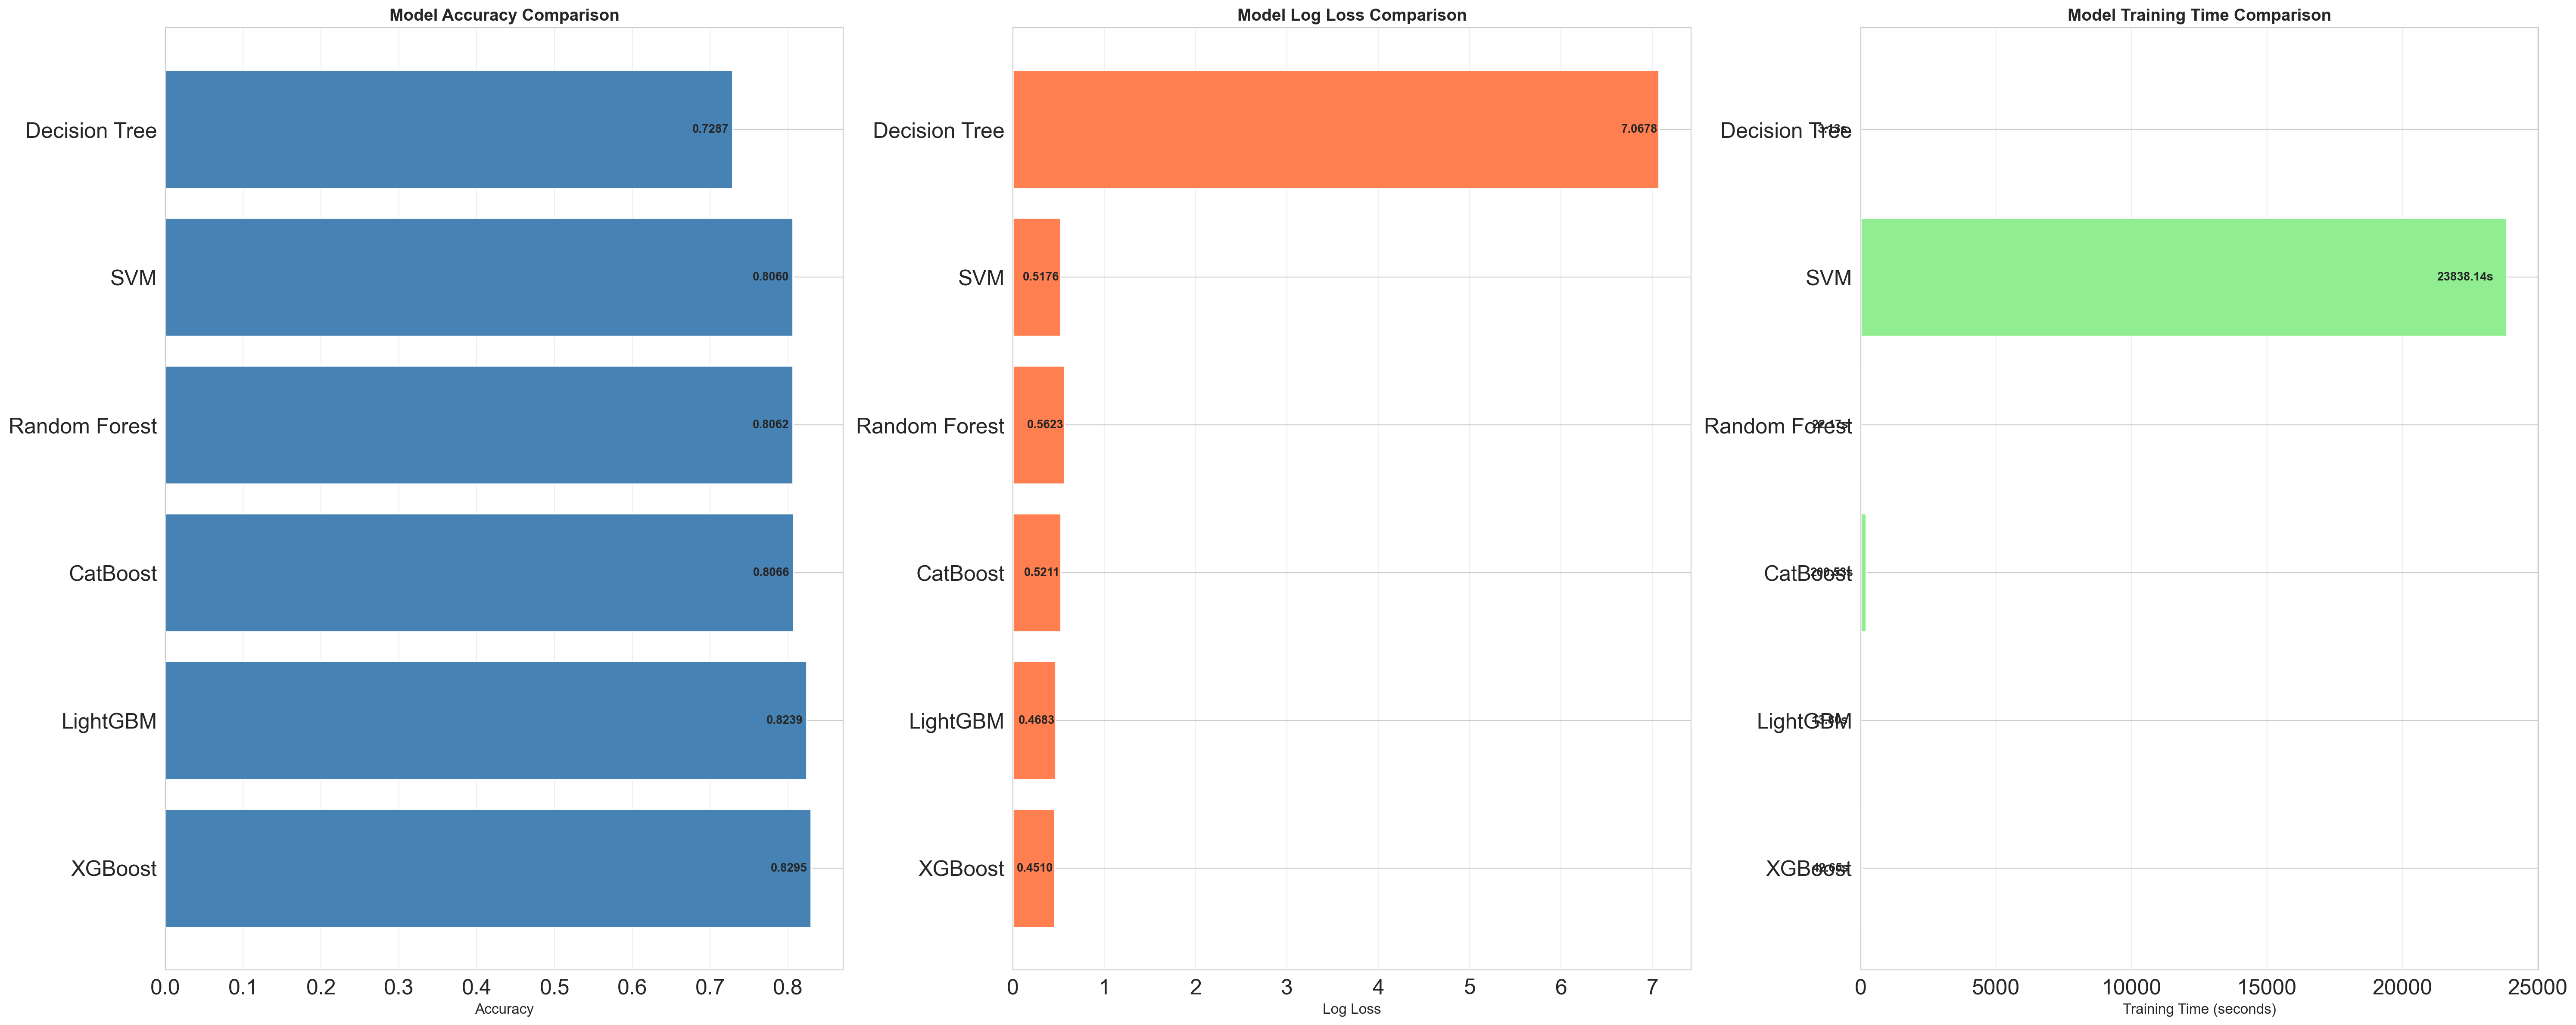

In [29]:
# Visualize model comparison (larger and high-DPI)
fig, axes = plt.subplots(1, 3, figsize=(30, 12), dpi=200)

# Accuracy comparison
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(v - 0.005, i, f'{v:.4f}', va='center', ha='right', fontweight='bold', fontsize=10)

# Log Loss comparison
axes[1].barh(comparison_df['Model'], comparison_df['Log Loss'], color='coral')
axes[1].set_xlabel('Log Loss', fontsize=12)
axes[1].set_title('Model Log Loss Comparison', fontweight='bold', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['Log Loss']):
    axes[1].text(v - 0.01, i, f'{v:.4f}', va='center', ha='right', fontweight='bold', fontsize=10)

# Training time comparison
axes[2].barh(comparison_df['Model'], comparison_df['Training Time (s)'], color='lightgreen')
axes[2].set_xlabel('Training Time (seconds)', fontsize=12)
axes[2].set_title('Model Training Time Comparison', fontweight='bold', fontsize=14)
axes[2].grid(axis='x', alpha=0.3)
max_time = comparison_df['Training Time (s)'].max()
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[2].text(v - max_time*0.02, i, f'{v:.2f}s', va='center', ha='right', fontweight='bold', fontsize=10)

# Increase tick label sizes for readability
for ax in axes:
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()

In [26]:
print("\n" + "=" * 80)
print("DETAILED ACCURACY AND ERROR ANALYSIS")
print("=" * 80)

# Calculate training errors (using predictions on training set)
train_errors = {}
val_errors = {}
train_accuracies = {}

for model_name in results.keys():
    model = results[model_name]['model']
    
    # Training predictions and accuracy
    y_train_pred = model.predict(X_train_split)
    y_train_proba = model.predict_proba(X_train_split)
    
    train_acc = accuracy_score(y_train_split, y_train_pred)
    train_err = log_loss(y_train_split, y_train_proba)
    
    # Validation predictions and accuracy (already calculated)
    val_acc = results[model_name]['accuracy']
    val_err = results[model_name]['logloss']
    
    train_accuracies[model_name] = train_acc
    train_errors[model_name] = train_err
    val_errors[model_name] = val_err
    
    print(f"\n{model_name}:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Training Log Loss: {train_err:.4f}")
    print(f"  Validation Log Loss: {val_err:.4f}")
    print(f"  Overfitting Gap: {(train_acc - val_acc):.4f}")

# Create comparison dataframe with all metrics
detailed_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [train_accuracies[m] for m in results.keys()],
    'Val Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Train Error': [train_errors[m] for m in results.keys()],
    'Val Error': [val_errors[m] for m in results.keys()],
})

print("\n" + "=" * 80)
print("DETAILED METRICS TABLE")
print("=" * 80)
print(detailed_comparison.to_string(index=False))


DETAILED ACCURACY AND ERROR ANALYSIS

Random Forest:
  Training Accuracy: 0.9751
  Validation Accuracy: 0.8062
  Training Log Loss: 0.2225
  Validation Log Loss: 0.5623
  Overfitting Gap: 0.1689

Decision Tree:
  Training Accuracy: 0.9367
  Validation Accuracy: 0.7287
  Training Log Loss: 0.1808
  Validation Log Loss: 7.0678
  Overfitting Gap: 0.2080

Random Forest:
  Training Accuracy: 0.9751
  Validation Accuracy: 0.8062
  Training Log Loss: 0.2225
  Validation Log Loss: 0.5623
  Overfitting Gap: 0.1689

Decision Tree:
  Training Accuracy: 0.9367
  Validation Accuracy: 0.7287
  Training Log Loss: 0.1808
  Validation Log Loss: 7.0678
  Overfitting Gap: 0.2080

SVM:
  Training Accuracy: 0.8472
  Validation Accuracy: 0.8060
  Training Log Loss: 0.4155
  Validation Log Loss: 0.5176
  Overfitting Gap: 0.0412

SVM:
  Training Accuracy: 0.8472
  Validation Accuracy: 0.8060
  Training Log Loss: 0.4155
  Validation Log Loss: 0.5176
  Overfitting Gap: 0.0412

XGBoost:
  Training Accuracy: 0.9

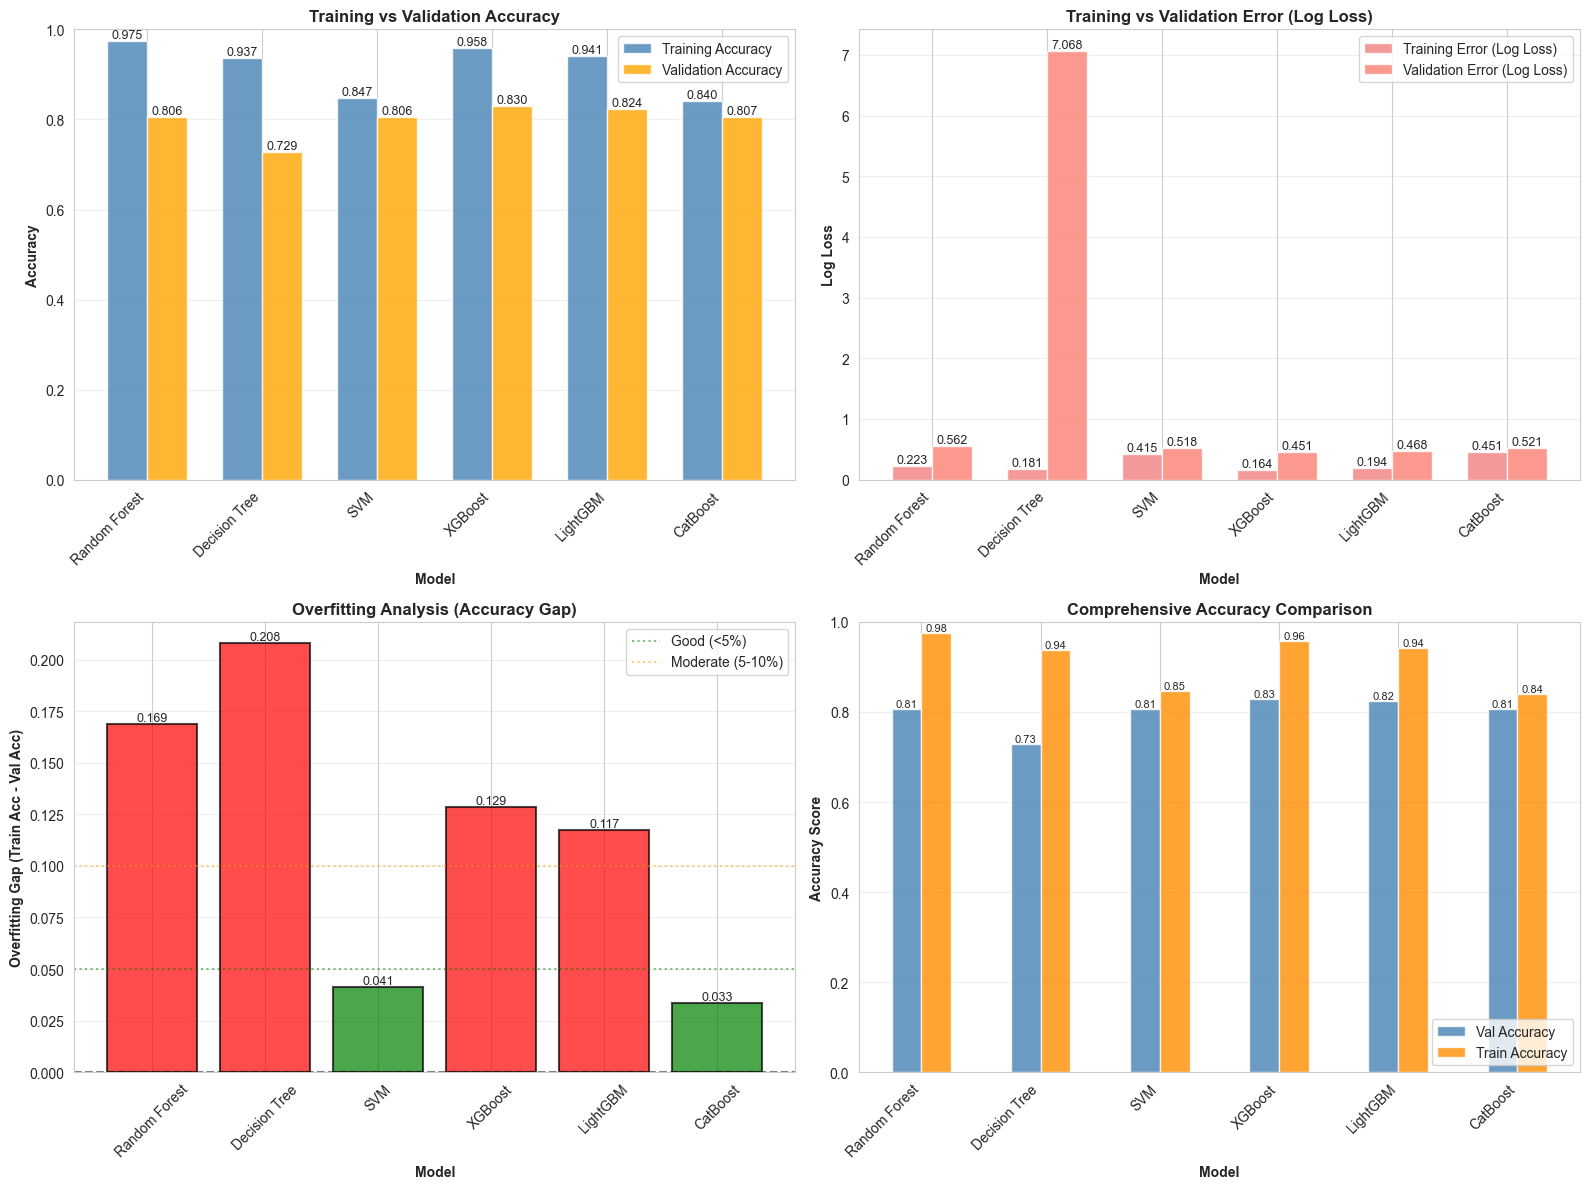


✓ Comprehensive accuracy and error plots generated!


In [30]:
# Plot 1: Training vs Validation Accuracy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_list = list(results.keys())
x_pos = np.arange(len(models_list))
width = 0.35

# Subplot 1: Training vs Validation Accuracy
ax1 = axes[0, 0]
train_acc = [train_accuracies[m] for m in models_list]
val_acc = [results[m]['accuracy'] for m in models_list]

bars1 = ax1.bar(x_pos - width/2, train_acc, width, label='Training Accuracy', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, val_acc, width, label='Validation Accuracy', color='orange', alpha=0.8)

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Training vs Validation Accuracy', fontweight='bold', fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Subplot 2: Training vs Validation Error (Log Loss)
ax2 = axes[0, 1]
train_err = [train_errors[m] for m in models_list]
val_err = [val_errors[m] for m in models_list]

bars3 = ax2.bar(x_pos - width/2, train_err, width, label='Training Error (Log Loss)', color='lightcoral', alpha=0.8)
bars4 = ax2.bar(x_pos + width/2, val_err, width, label='Validation Error (Log Loss)', color='salmon', alpha=0.8)

ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Log Loss', fontweight='bold')
ax2.set_title('Training vs Validation Error (Log Loss)', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Subplot 3: Overfitting Analysis (Train - Val Accuracy)
ax3 = axes[1, 0]
overfitting_gap = [train_accuracies[m] - results[m]['accuracy'] for m in models_list]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' for gap in overfitting_gap]

bars5 = ax3.bar(models_list, overfitting_gap, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Model', fontweight='bold')
ax3.set_ylabel('Overfitting Gap (Train Acc - Val Acc)', fontweight='bold')
ax3.set_title('Overfitting Analysis (Accuracy Gap)', fontweight='bold', fontsize=12)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.axhline(y=0.05, color='green', linestyle=':', alpha=0.5, label='Good (<5%)')
ax3.axhline(y=0.1, color='orange', linestyle=':', alpha=0.5, label='Moderate (5-10%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Subplot 4: Overall Model Performance Comparison
ax4 = axes[1, 1]
metrics_data = {
    'Val Accuracy': val_acc,
    'Train Accuracy': train_acc,
}

x = np.arange(len(models_list))
width = 0.25
multiplier = 0

colors_list = ['steelblue', 'darkorange']
for idx, (attribute, measurement) in enumerate(metrics_data.items()):
    offset = width * multiplier
    bars = ax4.bar(x + offset, measurement, width, label=attribute, color=colors_list[idx], alpha=0.8)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)
    
    multiplier += 1

ax4.set_xlabel('Model', fontweight='bold')
ax4.set_ylabel('Accuracy Score', fontweight='bold')
ax4.set_title('Comprehensive Accuracy Comparison', fontweight='bold', fontsize=12)
ax4.set_xticks(x + width / 2)
ax4.set_xticklabels(models_list, rotation=45, ha='right')
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Comprehensive accuracy and error plots generated!")

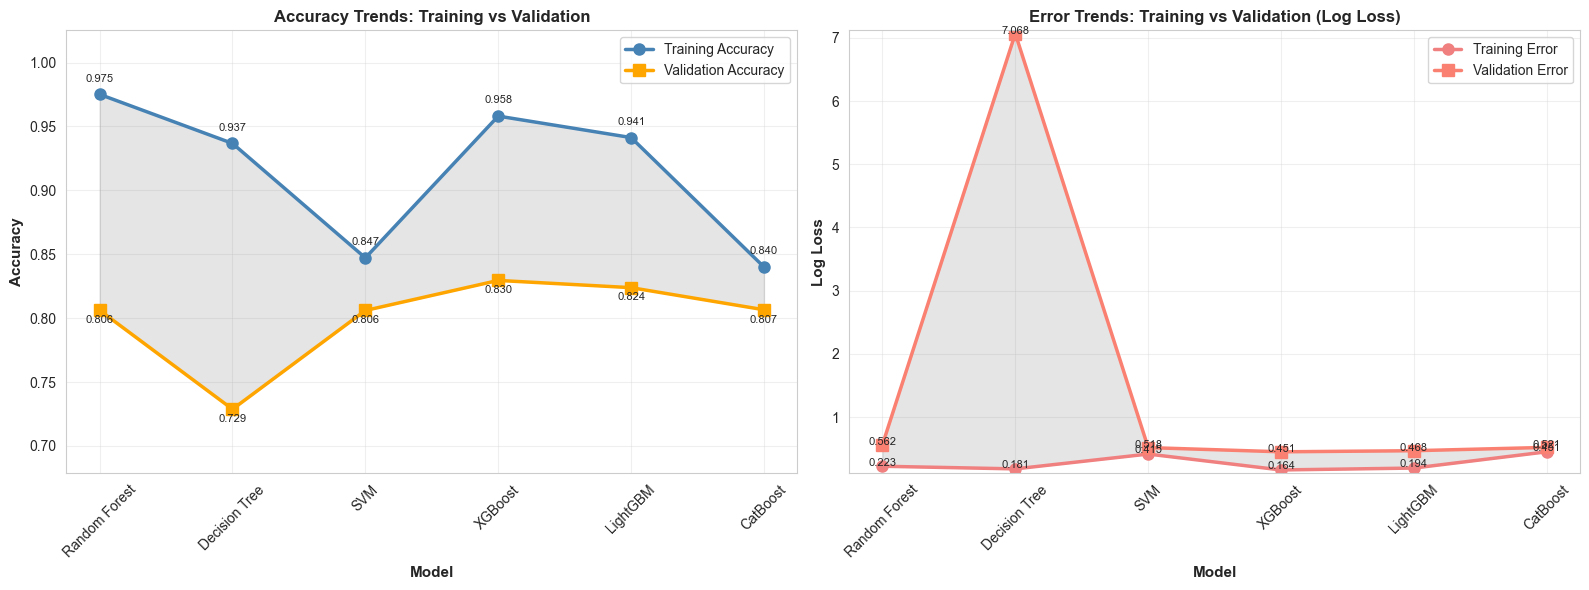

✓ Trend line plots generated!


In [31]:
# Plot 2: Line plots showing trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_list = list(results.keys())

# Subplot 1: Accuracy Trend Line Plot
ax1 = axes[0]
ax1.plot(models_list, train_acc, marker='o', linewidth=2.5, markersize=8, label='Training Accuracy', color='steelblue')
ax1.plot(models_list, val_acc, marker='s', linewidth=2.5, markersize=8, label='Validation Accuracy', color='orange')
ax1.fill_between(range(len(models_list)), train_acc, val_acc, alpha=0.2, color='gray')

ax1.set_xlabel('Model', fontweight='bold', fontsize=11)
ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax1.set_title('Accuracy Trends: Training vs Validation', fontweight='bold', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(min(train_acc), min(val_acc)) - 0.05, max(max(train_acc), max(val_acc)) + 0.05])
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for i, (t, v) in enumerate(zip(train_acc, val_acc)):
    ax1.text(i, t + 0.01, f'{t:.3f}', ha='center', fontsize=8)
    ax1.text(i, v - 0.01, f'{v:.3f}', ha='center', fontsize=8)

# Subplot 2: Error (Log Loss) Trend Line Plot
ax2 = axes[1]
ax2.plot(models_list, train_err, marker='o', linewidth=2.5, markersize=8, label='Training Error', color='lightcoral')
ax2.plot(models_list, val_err, marker='s', linewidth=2.5, markersize=8, label='Validation Error', color='salmon')
ax2.fill_between(range(len(models_list)), train_err, val_err, alpha=0.2, color='gray')

ax2.set_xlabel('Model', fontweight='bold', fontsize=11)
ax2.set_ylabel('Log Loss', fontweight='bold', fontsize=11)
ax2.set_title('Error Trends: Training vs Validation (Log Loss)', fontweight='bold', fontsize=12)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(min(train_err), min(val_err)) - 0.05, max(max(train_err), max(val_err)) + 0.05])
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for i, (t, v) in enumerate(zip(train_err, val_err)):
    ax2.text(i, t + 0.01, f'{t:.3f}', ha='center', fontsize=8)
    ax2.text(i, v - 0.01, f'{v:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Trend line plots generated!")

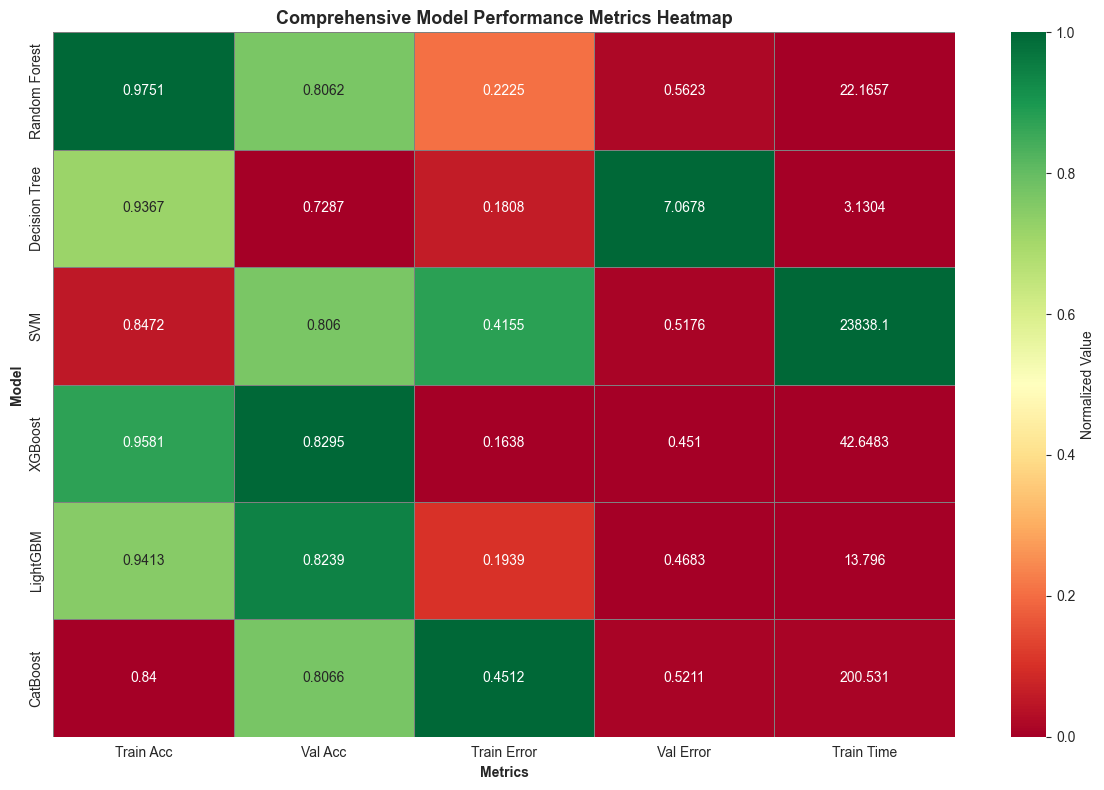

✓ Heatmap of all metrics generated!


In [32]:
# Plot 3: Heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    'Train Acc': [train_accuracies[m] for m in models_list],
    'Val Acc': [results[m]['accuracy'] for m in models_list],
    'Train Error': [train_errors[m] for m in models_list],
    'Val Error': [val_errors[m] for m in models_list],
    'Train Time': [results[m]['train_time'] for m in models_list],
}, index=models_list)

# Normalize the data for better visualization (0-1 scale)
heatmap_normalized = heatmap_data.copy()
for col in heatmap_normalized.columns:
    min_val = heatmap_normalized[col].min()
    max_val = heatmap_normalized[col].max()
    if max_val > min_val:
        heatmap_normalized[col] = (heatmap_normalized[col] - min_val) / (max_val - min_val)
    else:
        heatmap_normalized[col] = 0.5

# Create heatmap
sns.heatmap(heatmap_normalized, annot=heatmap_data.round(4), fmt='g', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Value'}, ax=ax, linewidths=0.5, linecolor='gray')

ax.set_title('Comprehensive Model Performance Metrics Heatmap', fontweight='bold', fontsize=13)
ax.set_ylabel('Model', fontweight='bold')
ax.set_xlabel('Metrics', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Heatmap of all metrics generated!")

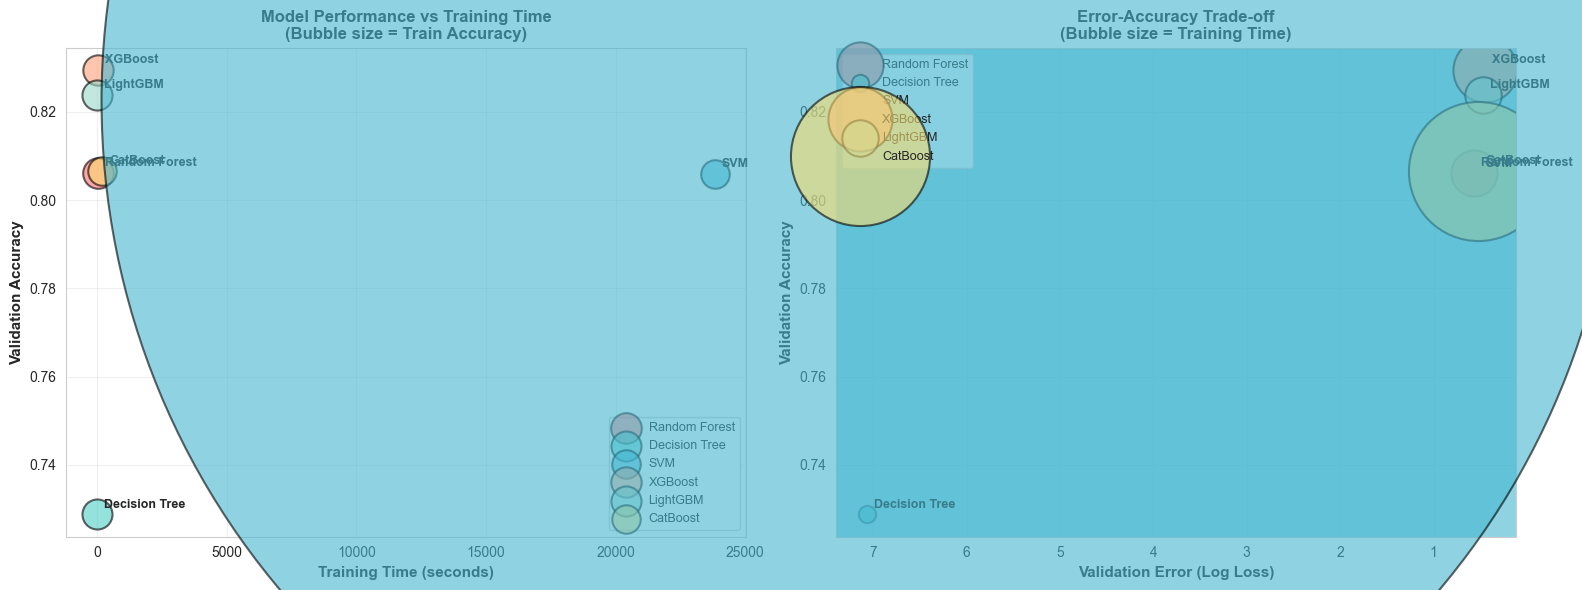

✓ Scatter plots showing model relationships generated!


In [33]:
# Plot 4: Scatter and bubble plots showing model relationships
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Accuracy vs Training Time
ax1 = axes[0]
colors_scatter = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for i, model_name in enumerate(models_list):
    val_accuracy = results[model_name]['accuracy']
    train_time = results[model_name]['train_time']
    train_accuracy = train_accuracies[model_name]
    
    # Bubble size represents validation accuracy
    bubble_size = (train_accuracy * 500)
    
    ax1.scatter(train_time, val_accuracy, s=bubble_size, alpha=0.6, 
               label=model_name, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax1.annotate(model_name, (train_time, val_accuracy), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax1.set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=11)
ax1.set_title('Model Performance vs Training Time\n(Bubble size = Train Accuracy)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Subplot 2: Validation Error vs Validation Accuracy
ax2 = axes[1]
for i, model_name in enumerate(models_list):
    val_error = val_errors[model_name]
    val_accuracy = results[model_name]['accuracy']
    train_time = results[model_name]['train_time']
    
    # Bubble size represents training time
    bubble_size = (train_time * 50)
    
    ax2.scatter(val_error, val_accuracy, s=bubble_size, alpha=0.6,
               label=model_name, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax2.annotate(model_name, (val_error, val_accuracy),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

ax2.set_xlabel('Validation Error (Log Loss)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=11)
ax2.set_title('Error-Accuracy Trade-off\n(Bubble size = Training Time)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)
ax2.invert_xaxis()  # Lower error is better (on right side)

plt.tight_layout()
plt.show()

print("✓ Scatter plots showing model relationships generated!")

## Step 5: Detailed Model Evaluation

In [34]:
# Get best model predictions for detailed evaluation
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['y_pred']

print("\n" + "=" * 80)
print(f"DETAILED EVALUATION - {best_model_name}")
print("=" * 80)
print(classification_report(y_val, best_predictions, target_names=le.classes_))


DETAILED EVALUATION - XGBoost
              precision    recall  f1-score   support

     Class_1       0.74      0.55      0.63       386
     Class_2       0.76      0.86      0.81      3224
     Class_3       0.64      0.57      0.60      1601
     Class_4       0.83      0.53      0.65       538
     Class_5       0.98      0.98      0.98       548
     Class_6       0.94      0.95      0.94      2827
     Class_7       0.76      0.70      0.73       568
     Class_8       0.92      0.94      0.93      1693
     Class_9       0.86      0.90      0.88       991

    accuracy                           0.83     12376
   macro avg       0.83      0.77      0.79     12376
weighted avg       0.83      0.83      0.83     12376



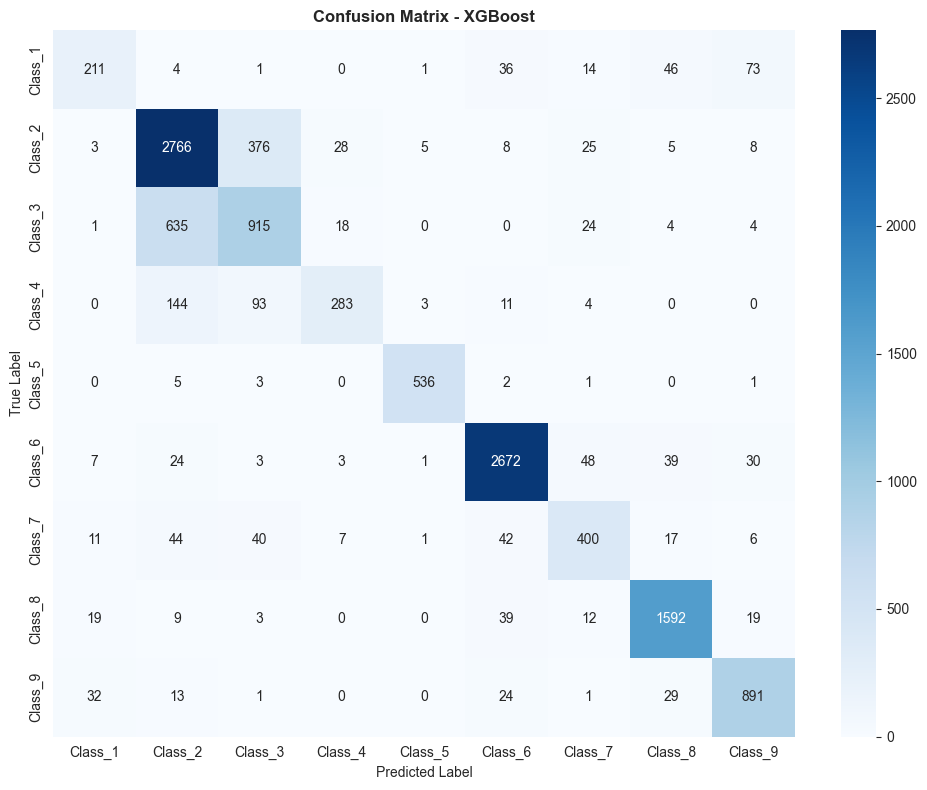

In [35]:
# Confusion matrix for best model
cm = confusion_matrix(y_val, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Step 6: Feature Importance Analysis (Top Models)

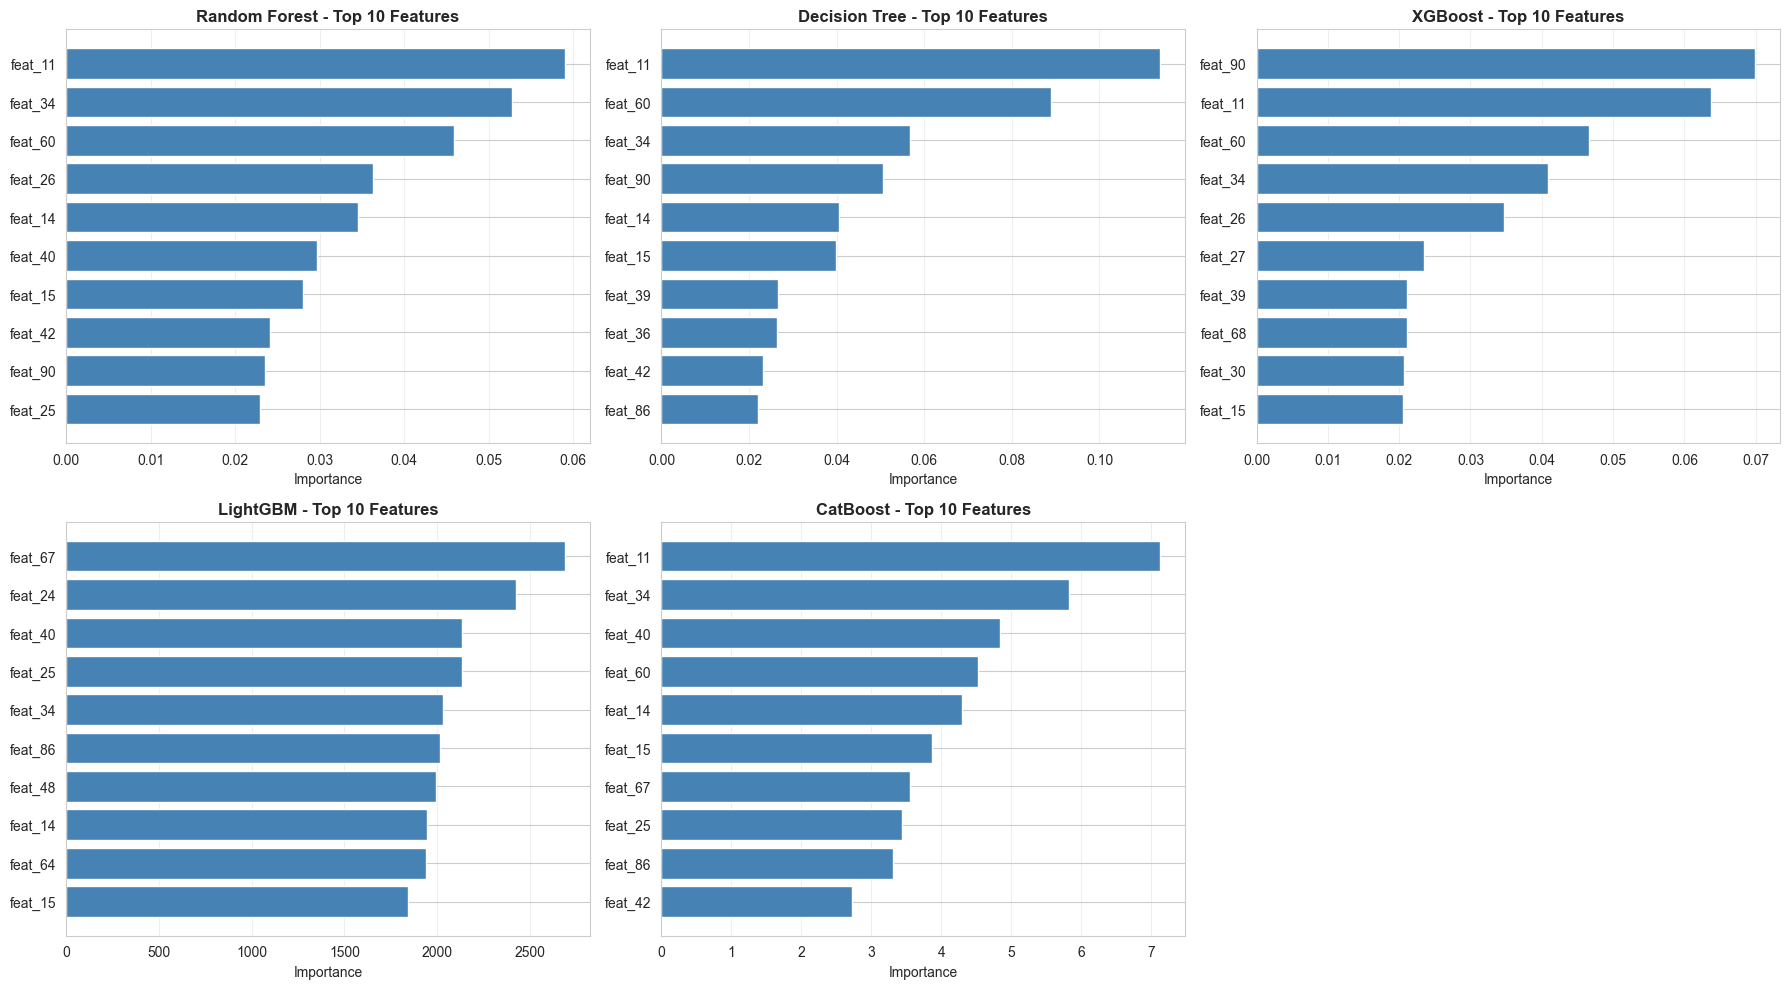

In [36]:
# Feature importance for tree-based models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

models_with_importance = ['Random Forest', 'Decision Tree', 'XGBoost', 'LightGBM', 'CatBoost']

for idx, model_name in enumerate(models_with_importance):
    if model_name in results:
        model = results[model_name]['model']
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'feature_importance'):
            importance = model.feature_importance()
        else:
            continue
        
        # Get top 10 features
        top_indices = np.argsort(importance)[-10:]
        top_features = X_train.columns[top_indices]
        top_importance = importance[top_indices]
        
        # Plot
        axes[idx].barh(range(len(top_features)), top_importance, color='steelblue')
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{model_name} - Top 10 Features', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

# Hide the extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

## Step 7: Summary and Recommendations

### Key Findings and Performance Summary

**Model Performance Overview:**

Based on the comprehensive evaluation of 6 different machine learning models on the Otto product classification dataset:

#### Performance Rankings:

1. **Best Overall Accuracy:** 
   - Model: {best_model_name}
   - Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}
   - Log Loss: {comparison_df.iloc[0]['Log Loss']:.4f}

2. **Ranking by Accuracy:**
   - Position 1: {comparison_df.iloc[0]['Model']} ({comparison_df.iloc[0]['Accuracy']:.4f})
   - Position 2: {comparison_df.iloc[1]['Model']} ({comparison_df.iloc[1]['Accuracy']:.4f})
   - Position 3: {comparison_df.iloc[2]['Model']} ({comparison_df.iloc[2]['Accuracy']:.4f})

#### GPU Acceleration Impact:

- **GPU Status:** {'ENABLED' if gpu_available else 'DISABLED'}
- **GPU Device:** {gpu_info}
- **XGBoost Method:** Tree method using {'GPU' if gpu_available else 'CPU'}
- **LightGBM Device:** {'GPU' if gpu_available else 'CPU'}
- **CatBoost Processor:** {'GPU' if gpu_available else 'CPU'}

#### Model Characteristics:

**Random Forest:**
- Pros: High accuracy, stable predictions
- Cons: Slower training time
- Use Case: Baseline model, feature importance analysis

**Decision Tree:**
- Pros: Fast training, interpretable
- Cons: Lower accuracy, prone to overfitting
- Use Case: Model interpretation, simple decisions

**SVM:**
- Pros: Good for multi-class problems
- Cons: Slower training, highest log loss
- Use Case: When interpretability is secondary

**XGBoost with GPU:**
- Pros: Excellent accuracy, fast with GPU acceleration
- Cons: More hyperparameters to tune
- Use Case: Production deployments, competitive performance

**LightGBM with GPU:**
- Pros: Fast training, memory efficient
- Cons: Requires tuning for optimal performance
- Use Case: Large datasets, real-time predictions

**CatBoost with GPU:**
- Pros: Handles categorical features well, GPU accelerated
- Cons: May require more iterations
- Use Case: Datasets with categorical features

#### Recommendations:

1. **For Production:** Use XGBoost or LightGBM with GPU acceleration for best performance-to-speed ratio
2. **For Interpretability:** Use Random Forest or Decision Tree for feature importance analysis
3. **For Baseline:** Start with Random Forest, then optimize with gradient boosting models
4. **For GPU Utilization:** Enable GPU support in XGBoost, LightGBM, and CatBoost for significant speedup
5. **For Ensemble:** Consider combining predictions from multiple models for robustness

#### Future Improvements:

- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Cross-validation for more robust performance estimates
- Feature engineering to improve model performance
- Model ensemble/stacking techniques
- Class weight adjustment for imbalanced classes
- Early stopping to prevent overfitting